### DPCN Team Baby Sharks Project
- Amey Choudhary
- Aryan Gupta
- Keshav Gupta

# EMD

Empirical Mode Decomposition (EMD) is a technique used to break down complex data into simpler parts (just like separating the different instruments in a piece of music so we can hear each one clearly), these simpler parts are called Intrinsic Mode Functions (IMF), and each one represents a different rhythm or pattern in the data. There's a residue, which is the leftover trend after all the patterns have been removed.

### How EMD Works
1. **Identification of Extremes**: Detect all local maxima and minima of the signal.
2. **Envelope Interpolation**: Draw smooth curves (envelopes) through themaximas and minimas.
3. **Mean Envelope Calculation**: EMD calculates the average of these two curves. 
4. **Extraction of IMF**: The difference between the data and this average line is called an IMF. It shows one of the underlying patterns or cycles in the data.
5. **Repeat**: The remaining data (after subtracting the IMF) is treated as new data, and the process repeats. Each time, a new IMF is found, revealing another pattern.
6. **Stop**: Stop when the residue becomes a monotonic function, which cannot be decomposed further into meaningful IMFs.


### Why Use EMD?
EMD is a powerful tool for analyzing nonlinear and non-stationary signals (unpredictable and time dependent, eg. dynamic real-world phenomena), allowing the extraction of meaningful oscillatory modes embedded within complex data sets. It is commonly used in various fields such as economics, medicine, and geophysics for trend analysis, noise reduction, and feature extraction.

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as  nn
import torch.optim as optim
import torch
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

In [2]:
# Selecting the dataset. Change the file path and type of data (Manual)
file_path ="./Datasets/Malaria_datasets/Venezuela_Malaria.xlsx"

# Reading the data
dataset = pd.read_excel(file_path)

print("The shape of the dataset: ", dataset.shape)
print("The first 5 entries are:" )
print(dataset.head())


The shape of the dataset:  (669, 2)
The first 5 entries are:
   Weeks  Cases
0      1    588
1      2    635
2      3    405
3      4    425
4      5    452


In [3]:
location = file_path.split("/")[-1].split("_")[0]
disease = file_path.split("/")[-1].split("_")[1].split(".")[0]

# selecting the hyperparameters for the dataset from excel
hyperparameters = pd.read_excel("./Suggested hyper-parameter values of EWNet model.xlsx")

# finding the hyperparameters for the dataset
for i in range(hyperparameters.shape[0]):
    name = hyperparameters.iloc[i, 0]
    loc = name.split(" ")[0]
    dis = name.split(" ")[1]
    if loc == location and dis == disease:
        hyperparameters_index = i
        break

# type of dataset as in weekly or monthly. need to set this manual after looking at the dataset values
type_of_dataset = "Weekly" # "Weekly" or "Monthly

# select the index of time , manual
index_of_cases = 1

# select the forecast type manually
forecast_type = "Medium" # "Short" or "Medium" or "Long"

p = hyperparameters[forecast_type][hyperparameters_index]
k = (p+1)//2

pred_length_weekly = {"Short": 13, "Medium": 26, "Long": 52}
pred_length_monthly = {"Short": 3, "Medium": 6, "Long": 12}

if type_of_dataset == "Weekly":
    pred_length = pred_length_weekly[forecast_type]
else:
    pred_length = pred_length_monthly[forecast_type]

test_size = pred_length
valid_size = 2*pred_length
train_size = dataset.shape[0] - test_size - valid_size-p # p is the lag, so train size wont contain the first p values


print("The value of p:",p)
print("The value of k:", k)
print("The prediction length is:", pred_length)



The value of p: 12
The value of k: 6
The prediction length is: 26


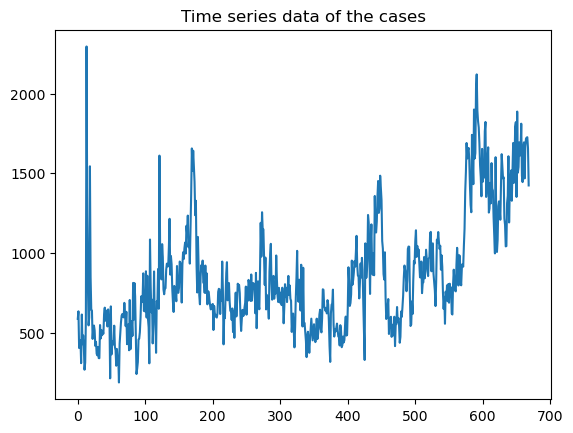

In [4]:
# changing to time series data
cases_time_series = dataset.iloc[:, index_of_cases].values
plt.plot(cases_time_series)
plt.title("Time series data of the cases")
plt.show()

# Performing EMD with custom code (Without Libraries)

In [5]:
def find_extremes(data):
    # Identify local maxima and minima
    d = np.diff(data)
    idx_min = np.where(np.diff(np.sign(d)) > 0)[0] + 1  # derivative -ve to +ve, minima
    idx_max = np.where(np.diff(np.sign(d)) < 0)[0] + 1  # derivative +ve to -ve, maxima
    if data[0] > data[1]:
        idx_max = np.insert(idx_max, 0, 0)
    elif data[0] < data[1]:
        idx_min = np.insert(idx_min, 0, 0)
    if data[-1] > data[-2]:
        idx_max = np.append(idx_max, len(data) - 1)
    elif data[-1] < data[-2]:
        idx_min = np.append(idx_min, len(data) - 1)
    return idx_min, idx_max

def emd_step(data):
    idx_min, idx_max = find_extremes(data)
    # Interpolate envelopes (curve passing through local minima or maxima)
    cs_min = CubicSpline(idx_min, data[idx_min])
    cs_max = CubicSpline(idx_max, data[idx_max])
    # Mean of upper and lower envelope
    env_mean = (cs_min(np.arange(len(data))) + cs_max(np.arange(len(data)))) / 2
    # Calculate first IMF
    imf = data - env_mean
    # env_mean (smooth line) middle of the peaks and troughs of the original data. 
    # remove the fastest changing details in the data, isolating the underlying trend or pattern in the process. 
    # extract the most prominent oscillations or cycles within the data (IMF)
    return imf, data - imf

In [6]:
cases_time_series_pruned = cases_time_series[0:train_size+valid_size+p]

# scaling the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1, 1))
cases_time_series_scaled = scaler.fit_transform(cases_time_series_pruned.reshape(-1, 1)).reshape(-1)


In [7]:
# doing signal decomposition using EMD
# # Manual EMD
# iterations = 15
# IMFs = []
# residue = cases_time_series_scaled
# for i in range(iterations):  
#     imf, residue = emd_step(residue)
#     IMFs.append(imf)
#     # residue is a monotonic function
#     if np.all(np.diff(residue) >= 0) or np.all(np.diff(residue) <= 0):  
#         break
# IMFs.append(residue)  

# using emd library
from PyEMD import EMD
emd = EMD()
IMFs = emd(cases_time_series_scaled)
n_imfs = IMFs.shape[0]

# IMFs = np.array(IMFs)
# n_imfs = len(IMFs)

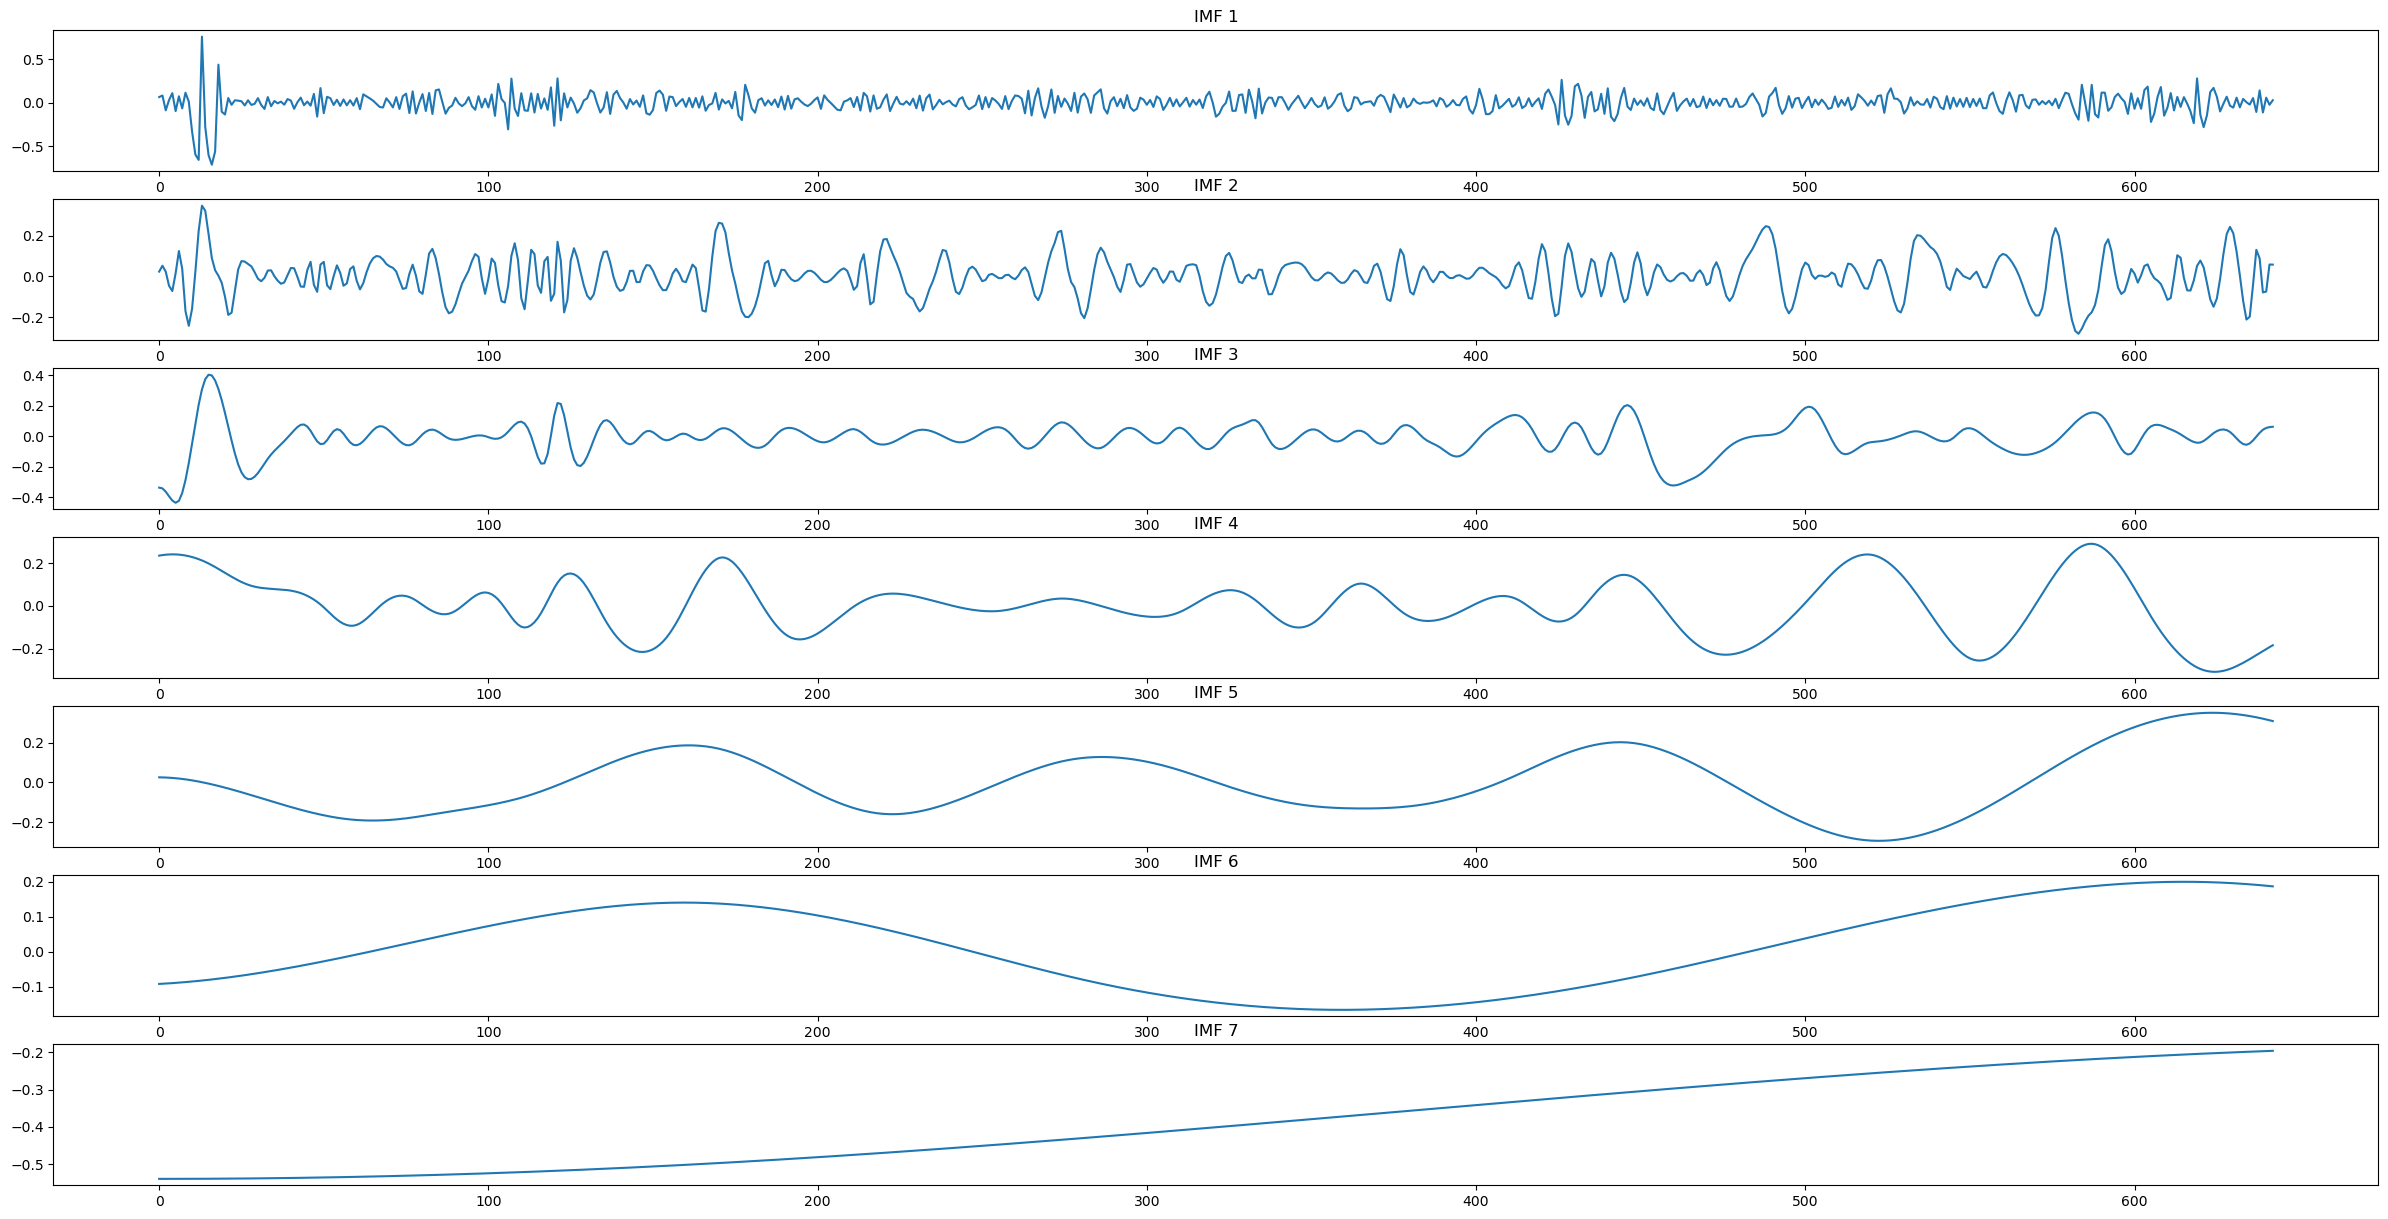

In [8]:
# plotting the IMFs
plt.figure(figsize=(30, 15))
for i in range(n_imfs):
    plt.subplot(n_imfs, 1, i+1)
    plt.plot(IMFs[i])
    plt.title("IMF "+str(i+1))
plt.show()


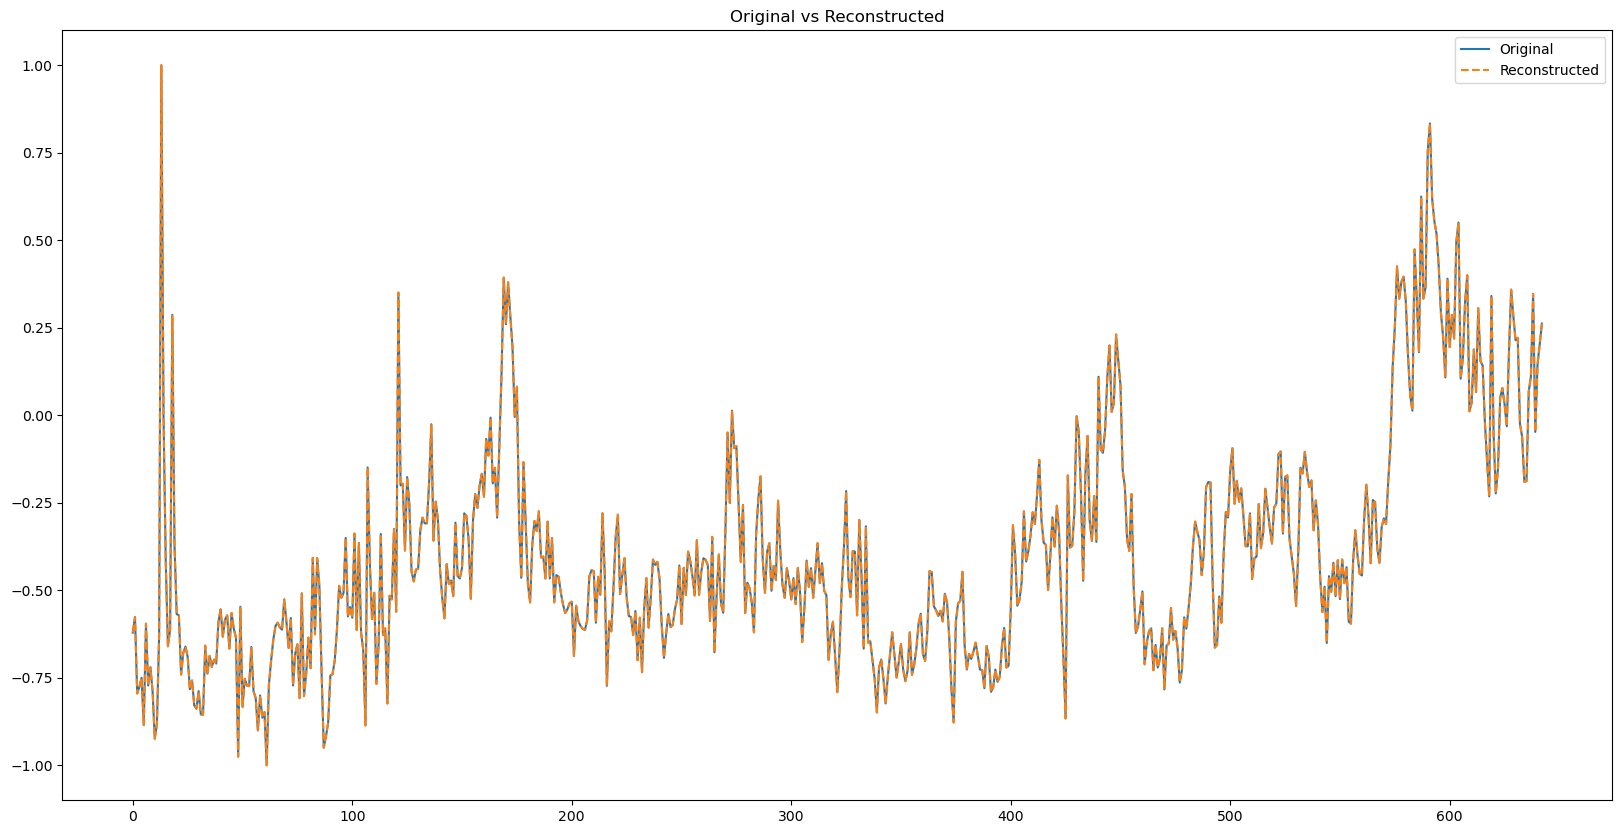

In [9]:
# checking the IMFs and actual
reconstructed_time_series = IMFs.sum(axis=0)
plt.figure(figsize=(20, 10))
plt.plot(cases_time_series_scaled, label="Original" )
plt.plot(reconstructed_time_series, label="Reconstructed", linestyle="--")
plt.title("Original vs Reconstructed")
plt.legend()
plt.show()

clearly the decomposition is done well

In [10]:
# creating the class for neural network
class EWNet(nn.Module):
    def __init__(self, p, k):
        super(EWNet, self).__init__()
        self.fc1 = nn.Linear(p, k)
        self.fc2 = nn.Linear(k, 1)
        self.act = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x


In [11]:
# creating the train dataset and test dataset

# Define function to create lagged sequences
def create_lagged_sequence(data, lag):
    X, y = [], []
    for i in range(len(data)-lag):
        X.append(data[i:(i+lag)])
        y.append(data[i+lag])
    return np.array(X), np.array(y)



X_train = []
y_train = []
X_valid = []
y_valid = []

for i in range(n_imfs):
    X, y = create_lagged_sequence(IMFs[i], p)
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32)
    X_train.append(X[0:train_size])
    y_train.append(y[0:train_size])
    X_valid.append(X[train_size:train_size+valid_size])
    y_valid.append(y[train_size:train_size+valid_size])

In [12]:
print("The shape of X_train[0]:", X_train[0].shape)
print("The shape of y_train[0]:", y_train[0].shape)
print("The shape of X_valid[0]:", X_valid[0].shape)
print("The shape of y_valid[0]:", y_valid[0].shape)

The shape of X_train[0]: torch.Size([579, 12])
The shape of y_train[0]: torch.Size([579])
The shape of X_valid[0]: torch.Size([52, 12])
The shape of y_valid[0]: torch.Size([52])


Training started for model:  1
Epoch:  0 Training Loss:  0.05596639961004257 Validation Loss:  0.05562984570860863
Epoch:  1000 Training Loss:  0.01001801248639822 Validation Loss:  0.011834103614091873
Epoch:  2000 Training Loss:  0.00951240211725235 Validation Loss:  0.01154977735131979
Epoch:  3000 Training Loss:  0.008839156478643417 Validation Loss:  0.011400450952351093
Epoch:  4000 Training Loss:  0.007448451593518257 Validation Loss:  0.011341691017150879
Epoch:  5000 Training Loss:  0.005939045920968056 Validation Loss:  0.011695515364408493
Epoch:  6000 Training Loss:  0.005295958369970322 Validation Loss:  0.012849373742938042
Epoch:  7000 Training Loss:  0.004889863543212414 Validation Loss:  0.013925185427069664
Epoch:  8000 Training Loss:  0.004615651909261942 Validation Loss:  0.014027849771082401
Epoch:  9000 Training Loss:  0.0044218976981937885 Validation Loss:  0.01420940924435854
Training completed for model:  1
Training started for model:  2
Epoch:  0 Training Loss

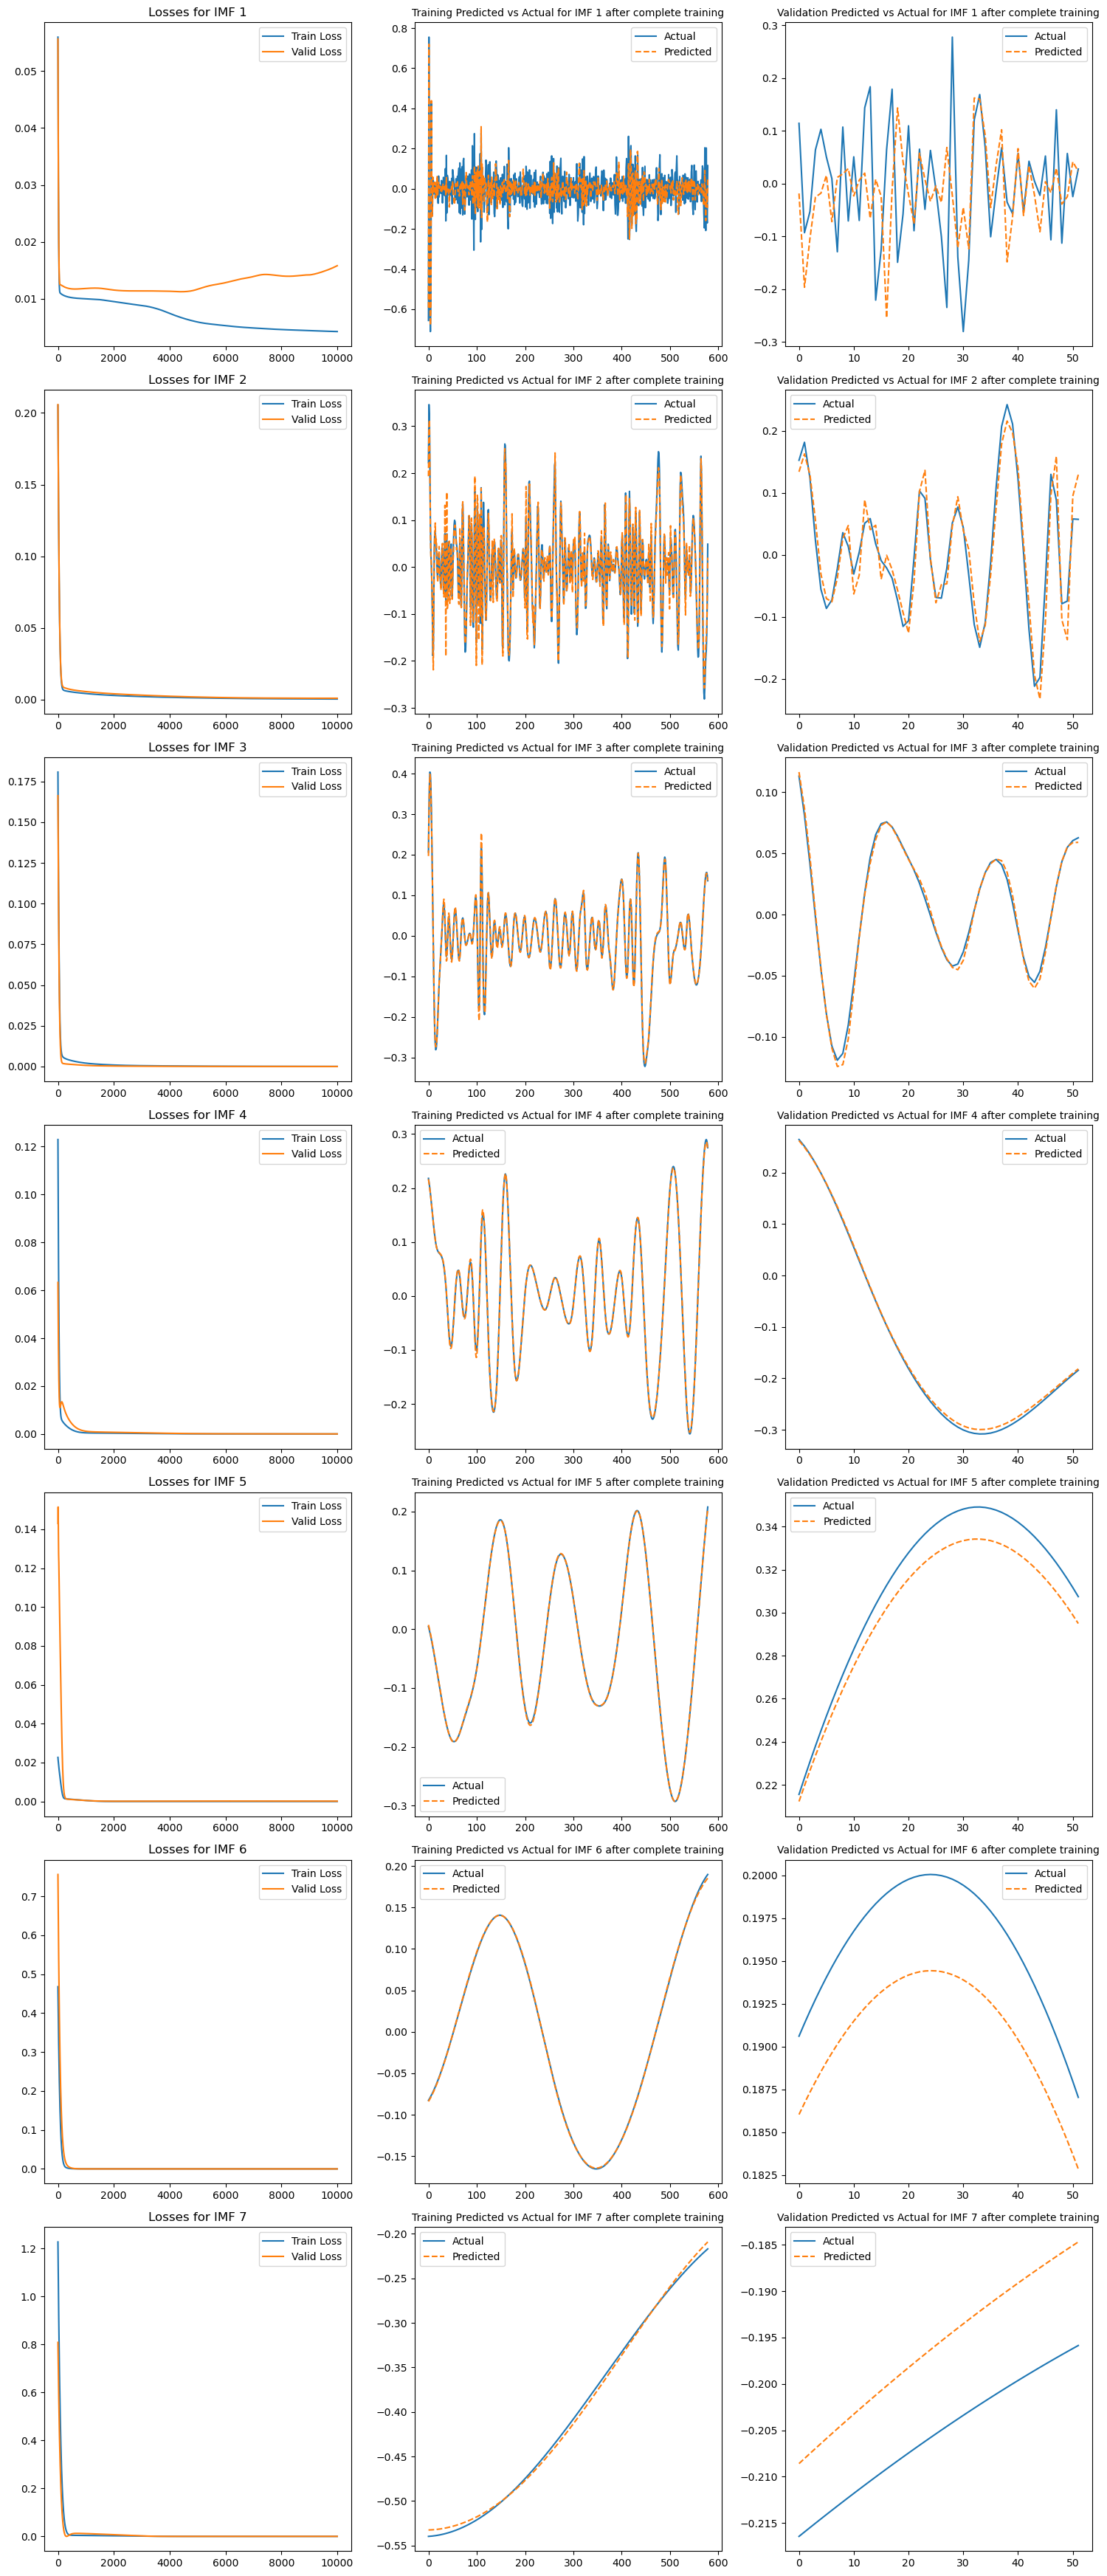

In [13]:
# running the model
n_models = []
fig, axes = plt.subplots(n_imfs, 3, figsize=(15, 5*n_imfs))

for i in range(n_imfs):
    # initializing the model
    model = EWNet(p, k)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epochs = 10000
    print_freq = 10
    epoch_freq = epochs//print_freq
    train_losses = []
    valid_losses = []

    print("Training started for model: ", i+1)
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        y_train_pred = model(X_train[i])
        y_train_pred = y_train_pred.view(-1)
        loss = criterion(y_train_pred, y_train[i])
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        with torch.no_grad():
            model.eval()
            y_valid_pred = model(X_valid[i])
            y_valid_pred = y_valid_pred.view(-1)
            valid_loss = criterion(y_valid_pred, y_valid[i])
            valid_losses.append(valid_loss.item())
        if epoch % epoch_freq == 0:
            print("Epoch: ", epoch, "Training Loss: ", loss.item(), "Validation Loss: ", valid_loss.item())
    print("Training completed for model: ", i+1)

    # Saving the model
    n_models.append(model)

    # Plot training and validation losses
    axes[i, 0].plot(train_losses, label="Train Loss")
    axes[i, 0].plot(valid_losses, label="Valid Loss")
    axes[i, 0].set_title("Losses for IMF "+str(i+1))
    axes[i, 0].legend()

    # Plotting the predicted vs actual for training
    axes[i, 1].plot(y_train[i], label="Actual")
    axes[i, 1].plot(y_train_pred.detach().numpy(), label="Predicted", linestyle="--")
    axes[i, 1].set_title("Training Predicted vs Actual for IMF "+str(i+1) + " after complete training" , fontsize=10)
    axes[i, 1].legend()

    # Plotting the predicted vs actual for validation
    axes[i, 2].plot(y_valid[i], label="Actual")
    axes[i, 2].plot(y_valid_pred.detach().numpy(), label="Predicted", linestyle="--")
    axes[i, 2].set_title("Validation Predicted vs Actual for IMF "+str(i+1) + " after complete training", fontsize=10)
    axes[i, 2].legend()

plt.tight_layout()
plt.show()


In [14]:
# testing the models
y_test_pred_final = []

for i in range(n_imfs):
    initial_input = IMFs[i][ -p:]
    y_test_pred_imfs = []
    model = n_models[i]
    model.eval()    
    with torch.no_grad():
        for j in range(test_size):
            y_pred = model(torch.tensor(initial_input[-p:], dtype=torch.float32))
            y_test_pred_imfs.append(y_pred.item())
            initial_input = np.append(initial_input, y_pred.item())
    y_test_pred_final.append(y_test_pred_imfs)

In [15]:
y_test_pred_final = np.array(y_test_pred_final)
y_test_pred_final = y_test_pred_final.sum(axis=0)
y_test_pred_final = scaler.inverse_transform(y_test_pred_final.reshape(-1, 1)).reshape(-1)

The results are:
         RMSE         MAE      MASE      sMAPE
0  365.267652  326.519447  1.918897  22.277122


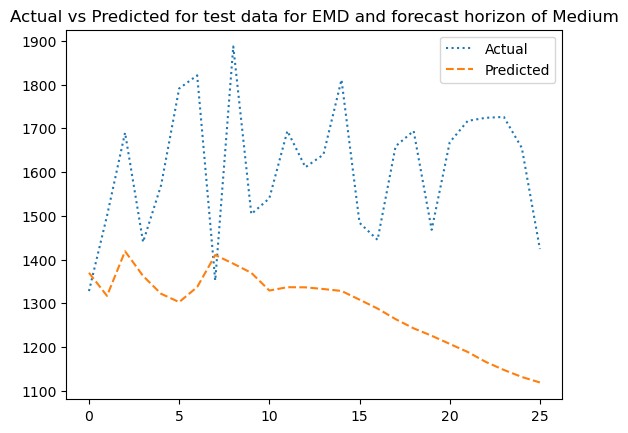

In [16]:
# calculating RMSE, MASE, MAE, sMAPE loss and  comparing the results
y_test_pred = np.array(y_test_pred_final)
y_test_true = np.array(cases_time_series[-test_size:])

rmse = np.sqrt(np.mean((y_test_pred - y_test_true)**2))
mae = np.mean(np.abs(y_test_pred - y_test_true))
mase = np.mean(np.abs(y_test_pred - y_test_true))/np.mean(np.abs(y_test_true[1:] - y_test_true[:-1]))
smape = 100*np.mean(2*np.abs(y_test_pred - y_test_true)/(np.abs(y_test_pred) + np.abs(y_test_true)))

# tabulate the results
results = pd.DataFrame({"RMSE": [rmse], "MAE": [mae], "MASE": [mase], "sMAPE": [smape]})
print("The results are:")
print(results)

plt.plot(y_test_true, label="Actual", linestyle= "dotted")
plt.plot(y_test_pred, label="Predicted", linestyle="--")
plt.title("Actual vs Predicted for test data for EMD and forecast horizon of "+forecast_type)
plt.legend()
plt.show()

   Weeks  Cases
0      1    588
1      2    635
2      3    405
3      4    425
4      5    452
Training completed for model for time:  Short  and model:  1
Training completed for model for time:  Short  and model:  2
Training completed for model for time:  Short  and model:  3
Training completed for model for time:  Short  and model:  4
Training completed for model for time:  Short  and model:  5
Training completed for model for time:  Short  and model:  6
Training completed for model for time:  Short  and model:  7
The results for time:  Short
         RMSE         MAE      MASE      sMAPE
0  341.482309  259.746116  1.982795  16.642275


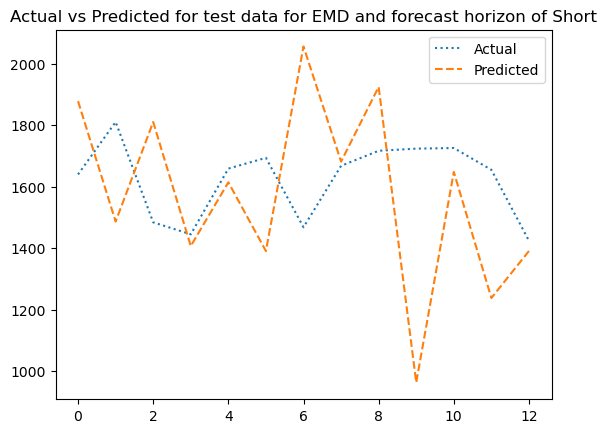

Training completed for model for time:  Medium  and model:  1
Training completed for model for time:  Medium  and model:  2
Training completed for model for time:  Medium  and model:  3
Training completed for model for time:  Medium  and model:  4
Training completed for model for time:  Medium  and model:  5
Training completed for model for time:  Medium  and model:  6
Training completed for model for time:  Medium  and model:  7
The results for time:  Medium
         RMSE        MAE      MASE      sMAPE
0  455.775946  404.49535  2.377147  28.685599


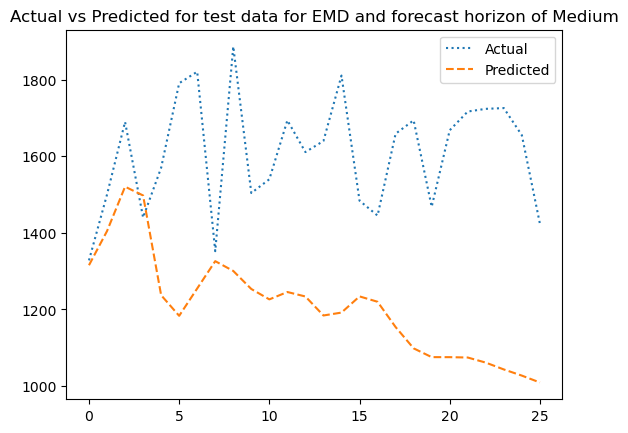

Training completed for model for time:  Long  and model:  1
Training completed for model for time:  Long  and model:  2
Training completed for model for time:  Long  and model:  3
Training completed for model for time:  Long  and model:  4
Training completed for model for time:  Long  and model:  5
Training completed for model for time:  Long  and model:  6
Training completed for model for time:  Long  and model:  7
The results for time:  Long
         RMSE         MAE      MASE      sMAPE
0  404.415762  350.410513  2.104692  25.982547


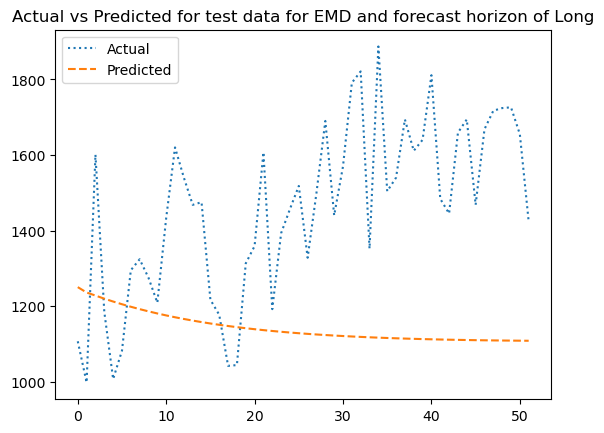

In [17]:
file_path ="./Datasets/Malaria_datasets/Venezuela_Malaria.xlsx"
dataset = pd.read_excel(file_path)
print(dataset.head())
index_of_cases = 1
type_of_dataset = "Weekly"
pred_length_weekly = {"Short": 13, "Medium": 26, "Long": 52}
pred_length_monthly = {"Short": 3, "Medium": 6, "Long": 12}

for i in range(hyperparameters.shape[0]):
    name = hyperparameters.iloc[i, 0]
    loc = name.split(" ")[0]
    dis = name.split(" ")[1]
    if loc == location and dis == disease:
        hyperparameters_index = i
        break


for time in ["Short", "Medium", "Long"]:
    p = hyperparameters[time][hyperparameters_index]
    k = (p+1)//2

    if type_of_dataset == "Weekly":
        pred_length = pred_length_weekly[time]
    else:
        pred_length = pred_length_monthly[time]

    test_size = pred_length
    valid_size = 2*pred_length
    train_size = dataset.shape[0] - test_size - valid_size-p 

    cases_time_series = dataset.iloc[:, index_of_cases].values
    cases_time_series_pruned = cases_time_series[0:train_size+valid_size+p]

    # scaling the data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    cases_time_series_scaled = scaler.fit_transform(cases_time_series_pruned.reshape(-1, 1)).reshape(-1)

    emd = EMD()
    IMFs = emd(cases_time_series_scaled)
    n_imfs = IMFs.shape[0]

    X_train = []
    y_train = []
    X_valid = []
    y_valid = []

    for i in range(n_imfs):
        X, y = create_lagged_sequence(IMFs[i], p)
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        X_train.append(X[0:train_size])
        y_train.append(y[0:train_size])
        X_valid.append(X[train_size:train_size+valid_size])
        y_valid.append(y[train_size:train_size+valid_size])

    n_models = []
    for i in range(n_imfs):
        # initializing the model
        model = EWNet(p, k)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        epochs = 10000
        print_freq = 10
        epoch_freq = epochs//print_freq
        train_losses = []
        valid_losses = []

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            y_train_pred = model(X_train[i])
            y_train_pred = y_train_pred.view(-1)
            loss = criterion(y_train_pred, y_train[i])
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            with torch.no_grad():
                model.eval()
                y_valid_pred = model(X_valid[i])
                y_valid_pred = y_valid_pred.view(-1)
                valid_loss = criterion(y_valid_pred, y_valid[i])
                valid_losses.append(valid_loss.item())
        print("Training completed for model for time: ", time, " and model: ", i+1)
        n_models.append(model)
    
    y_test_pred_final = []
    for i in range(n_imfs):
        initial_input = IMFs[i][ -p:]
        y_test_pred_imfs = []
        model = n_models[i]
        model.eval()    
        with torch.no_grad():
            for j in range(test_size):
                y_pred = model(torch.tensor(initial_input[-p:], dtype=torch.float32))
                y_test_pred_imfs.append(y_pred.item())
                initial_input = np.append(initial_input, y_pred.item())
        y_test_pred_final.append(y_test_pred_imfs)
    
    y_test_pred_final = np.array(y_test_pred_final)
    y_test_pred_final = y_test_pred_final.sum(axis=0)
    y_test_pred_final = scaler.inverse_transform(y_test_pred_final.reshape(-1, 1)).reshape(-1)

    y_test_pred = np.array(y_test_pred_final)
    y_test_true = np.array(cases_time_series[-test_size:])
    rmse = np.sqrt(np.mean((y_test_pred - y_test_true)**2))
    mae = np.mean(np.abs(y_test_pred - y_test_true))
    mase = np.mean(np.abs(y_test_pred - y_test_true))/np.mean(np.abs(y_test_true[1:] - y_test_true[:-1]))
    smape = 100*np.mean(2*np.abs(y_test_pred - y_test_true)/(np.abs(y_test_pred) + np.abs(y_test_true)))
    results = pd.DataFrame({"RMSE": [rmse], "MAE": [mae], "MASE": [mase], "sMAPE": [smape]})
    print("The results for time: ", time)
    print(results)
    plt.plot(y_test_true, label="Actual", linestyle= "dotted")
    plt.plot(y_test_pred, label="Predicted", linestyle="--")
    plt.title("Actual vs Predicted for test data for EMD and forecast horizon of "+time)
    plt.legend()
    plt.show()

   Week  Cases  Rainfall
0     1      0       0.0
1     2      4       0.0
2     3      0       0.0
3     4      1       0.0
4     5      2       0.0
Training completed for model for time:  Short  and model:  1
Training completed for model for time:  Short  and model:  2
Training completed for model for time:  Short  and model:  3
Training completed for model for time:  Short  and model:  4
Training completed for model for time:  Short  and model:  5
Training completed for model for time:  Short  and model:  6
Training completed for model for time:  Short  and model:  7
The results for time:  Short
        RMSE        MAE      MASE      sMAPE
0  18.372612  15.247914  2.231402  88.280225


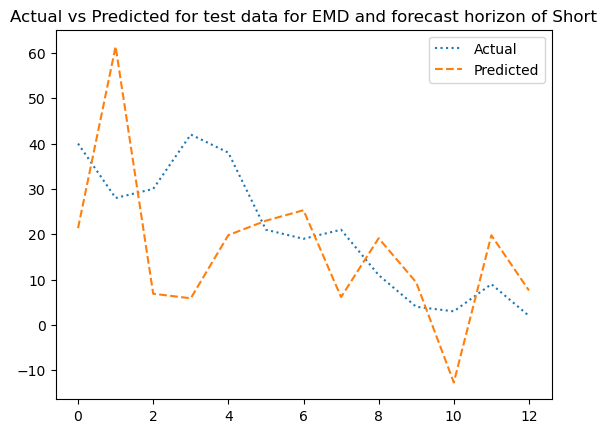

Training completed for model for time:  Medium  and model:  1
Training completed for model for time:  Medium  and model:  2
Training completed for model for time:  Medium  and model:  3
Training completed for model for time:  Medium  and model:  4
Training completed for model for time:  Medium  and model:  5
Training completed for model for time:  Medium  and model:  6
Training completed for model for time:  Medium  and model:  7
The results for time:  Medium
        RMSE        MAE      MASE       sMAPE
0  21.151647  17.922687  1.982598  108.180067


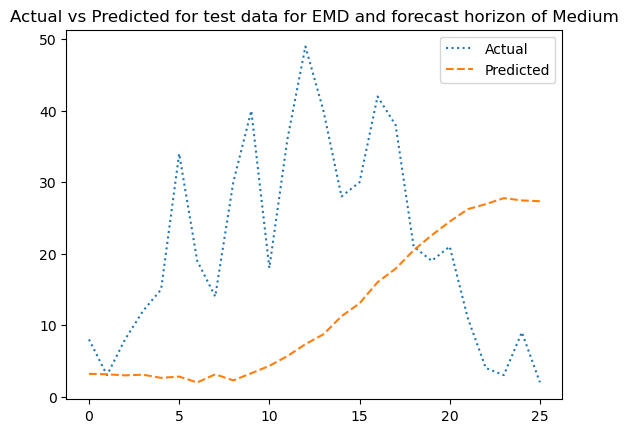

Training completed for model for time:  Long  and model:  1
Training completed for model for time:  Long  and model:  2
Training completed for model for time:  Long  and model:  3
Training completed for model for time:  Long  and model:  4
Training completed for model for time:  Long  and model:  5
Training completed for model for time:  Long  and model:  6
The results for time:  Long
        RMSE       MAE      MASE      sMAPE
0  13.334628  9.694146  1.865666  97.588262


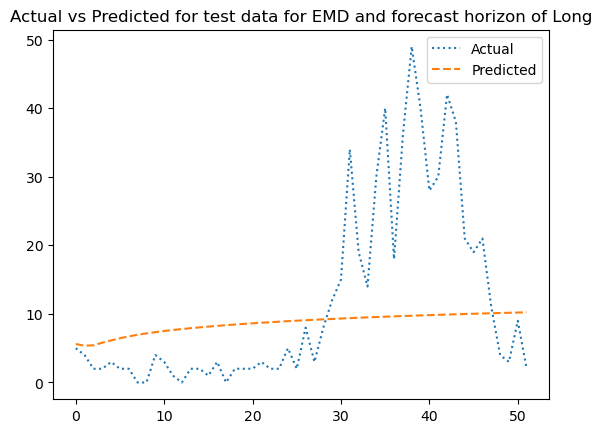

In [18]:
file_path ="Datasets/Dengue_datasets/Ahmedabad_Dengue.xlsx"
dataset = pd.read_excel(file_path)
print(dataset.head())
index_of_cases = 1
type_of_dataset = "Weekly"
pred_length_weekly = {"Short": 13, "Medium": 26, "Long": 52}
pred_length_monthly = {"Short": 3, "Medium": 6, "Long": 12}

for i in range(hyperparameters.shape[0]):
    name = hyperparameters.iloc[i, 0]
    loc = name.split(" ")[0]
    dis = name.split(" ")[1]
    if loc == location and dis == disease:
        hyperparameters_index = i
        break

for time in ["Short", "Medium", "Long"]:
    p = hyperparameters[time][hyperparameters_index]
    k = (p+1)//2

    if type_of_dataset == "Weekly":
        pred_length = pred_length_weekly[time]
    else:
        pred_length = pred_length_monthly[time]

    test_size = pred_length
    valid_size = 2*pred_length
    train_size = dataset.shape[0] - test_size - valid_size-p 

    cases_time_series = dataset.iloc[:, index_of_cases].values
    cases_time_series_pruned = cases_time_series[0:train_size+valid_size+p]

    # scaling the data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    cases_time_series_scaled = scaler.fit_transform(cases_time_series_pruned.reshape(-1, 1)).reshape(-1)

    emd = EMD()
    IMFs = emd(cases_time_series_scaled)
    n_imfs = IMFs.shape[0]

    X_train = []
    y_train = []
    X_valid = []
    y_valid = []

    for i in range(n_imfs):
        X, y = create_lagged_sequence(IMFs[i], p)
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        X_train.append(X[0:train_size])
        y_train.append(y[0:train_size])
        X_valid.append(X[train_size:train_size+valid_size])
        y_valid.append(y[train_size:train_size+valid_size])

    n_models = []
    for i in range(n_imfs):
        # initializing the model
        model = EWNet(p, k)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        epochs = 10000
        print_freq = 10
        epoch_freq = epochs//print_freq
        train_losses = []
        valid_losses = []

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            y_train_pred = model(X_train[i])
            y_train_pred = y_train_pred.view(-1)
            loss = criterion(y_train_pred, y_train[i])
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            with torch.no_grad():
                model.eval()
                y_valid_pred = model(X_valid[i])
                y_valid_pred = y_valid_pred.view(-1)
                valid_loss = criterion(y_valid_pred, y_valid[i])
                valid_losses.append(valid_loss.item())
        print("Training completed for model for time: ", time, " and model: ", i+1)
        n_models.append(model)
    
    y_test_pred_final = []
    for i in range(n_imfs):
        initial_input = IMFs[i][ -p:]
        y_test_pred_imfs = []
        model = n_models[i]
        model.eval()    
        with torch.no_grad():
            for j in range(test_size):
                y_pred = model(torch.tensor(initial_input[-p:], dtype=torch.float32))
                y_test_pred_imfs.append(y_pred.item())
                initial_input = np.append(initial_input, y_pred.item())
        y_test_pred_final.append(y_test_pred_imfs)
    
    y_test_pred_final = np.array(y_test_pred_final)
    y_test_pred_final = y_test_pred_final.sum(axis=0)
    y_test_pred_final = scaler.inverse_transform(y_test_pred_final.reshape(-1, 1)).reshape(-1)

    y_test_pred = np.array(y_test_pred_final)
    y_test_true = np.array(cases_time_series[-test_size:])
    rmse = np.sqrt(np.mean((y_test_pred - y_test_true)**2))
    mae = np.mean(np.abs(y_test_pred - y_test_true))
    mase = np.mean(np.abs(y_test_pred - y_test_true))/np.mean(np.abs(y_test_true[1:] - y_test_true[:-1]))
    smape = 100*np.mean(2*np.abs(y_test_pred - y_test_true)/(np.abs(y_test_pred) + np.abs(y_test_true)))
    results = pd.DataFrame({"RMSE": [rmse], "MAE": [mae], "MASE": [mase], "sMAPE": [smape]})
    print("The results for time: ", time)
    print(results)
    plt.plot(y_test_true, label="Actual", linestyle= "dotted")
    plt.plot(y_test_pred, label="Predicted", linestyle="--")
    plt.title("Actual vs Predicted for test data for EMD and forecast horizon of "+time)
    plt.legend()
    plt.show()

   Week  Cases
0     1      1
1     2      1
2     3      0
3     4      0
4     5      0
Training completed for model for time:  Short  and model:  1
Training completed for model for time:  Short  and model:  2
Training completed for model for time:  Short  and model:  3
Training completed for model for time:  Short  and model:  4
Training completed for model for time:  Short  and model:  5
Training completed for model for time:  Short  and model:  6
Training completed for model for time:  Short  and model:  7
Training completed for model for time:  Short  and model:  8
The results for time:  Short
        RMSE        MAE      MASE      sMAPE
0  81.495975  70.426865  3.492241  88.859336


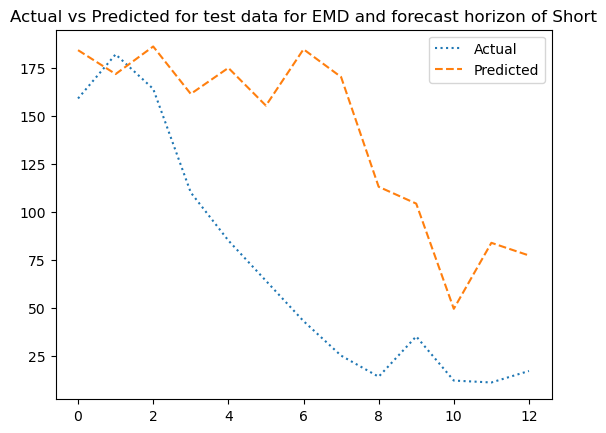

Training completed for model for time:  Medium  and model:  1
Training completed for model for time:  Medium  and model:  2
Training completed for model for time:  Medium  and model:  3
Training completed for model for time:  Medium  and model:  4
Training completed for model for time:  Medium  and model:  5
Training completed for model for time:  Medium  and model:  6
Training completed for model for time:  Medium  and model:  7
Training completed for model for time:  Medium  and model:  8
The results for time:  Medium
        RMSE        MAE      MASE      sMAPE
0  93.384722  79.733277  3.225456  73.349306


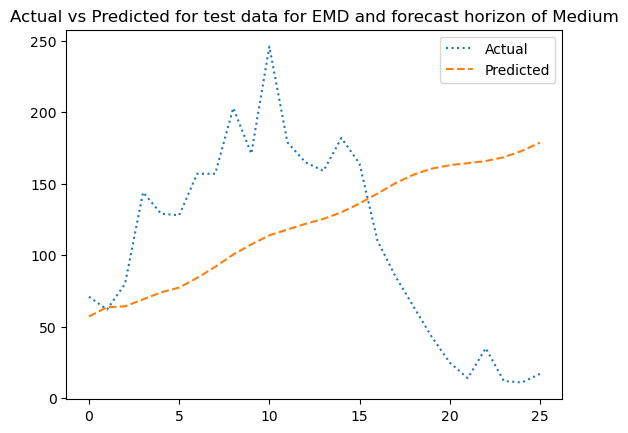

Training completed for model for time:  Long  and model:  1
Training completed for model for time:  Long  and model:  2
Training completed for model for time:  Long  and model:  3
Training completed for model for time:  Long  and model:  4
Training completed for model for time:  Long  and model:  5
Training completed for model for time:  Long  and model:  6
Training completed for model for time:  Long  and model:  7
Training completed for model for time:  Long  and model:  8
Training completed for model for time:  Long  and model:  9
The results for time:  Long
         RMSE         MAE      MASE  sMAPE
0  164.483573  148.910826  9.375867  200.0


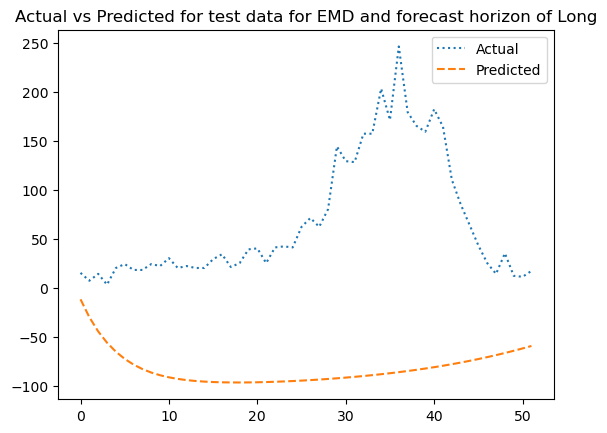

In [19]:
file_path ="Datasets/Influenza_datasets/Australia_Inflluenza.xlsx"
dataset = pd.read_excel(file_path)
print(dataset.head())
index_of_cases = 1
type_of_dataset = "Weekly"
pred_length_weekly = {"Short": 13, "Medium": 26, "Long": 52}
pred_length_monthly = {"Short": 3, "Medium": 6, "Long": 12}


for i in range(hyperparameters.shape[0]):
    name = hyperparameters.iloc[i, 0]
    loc = name.split(" ")[0]
    dis = name.split(" ")[1]
    if loc == location and dis == disease:
        hyperparameters_index = i
        break


for time in ["Short", "Medium", "Long"]:
    p = hyperparameters[time][hyperparameters_index]
    k = (p+1)//2

    if type_of_dataset == "Weekly":
        pred_length = pred_length_weekly[time]
    else:
        pred_length = pred_length_monthly[time]

    test_size = pred_length
    valid_size = 2*pred_length
    train_size = dataset.shape[0] - test_size - valid_size-p 

    cases_time_series = dataset.iloc[:, index_of_cases].values
    cases_time_series_pruned = cases_time_series[0:train_size+valid_size+p]

    # scaling the data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    cases_time_series_scaled = scaler.fit_transform(cases_time_series_pruned.reshape(-1, 1)).reshape(-1)

    emd = EMD()
    IMFs = emd(cases_time_series_scaled)
    n_imfs = IMFs.shape[0]

    X_train = []
    y_train = []
    X_valid = []
    y_valid = []

    for i in range(n_imfs):
        X, y = create_lagged_sequence(IMFs[i], p)
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        X_train.append(X[0:train_size])
        y_train.append(y[0:train_size])
        X_valid.append(X[train_size:train_size+valid_size])
        y_valid.append(y[train_size:train_size+valid_size])

    n_models = []
    for i in range(n_imfs):
        # initializing the model
        model = EWNet(p, k)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        epochs = 10000
        print_freq = 10
        epoch_freq = epochs//print_freq
        train_losses = []
        valid_losses = []

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            y_train_pred = model(X_train[i])
            y_train_pred = y_train_pred.view(-1)
            loss = criterion(y_train_pred, y_train[i])
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            with torch.no_grad():
                model.eval()
                y_valid_pred = model(X_valid[i])
                y_valid_pred = y_valid_pred.view(-1)
                valid_loss = criterion(y_valid_pred, y_valid[i])
                valid_losses.append(valid_loss.item())
        print("Training completed for model for time: ", time, " and model: ", i+1)
        n_models.append(model)
    
    y_test_pred_final = []
    for i in range(n_imfs):
        initial_input = IMFs[i][ -p:]
        y_test_pred_imfs = []
        model = n_models[i]
        model.eval()    
        with torch.no_grad():
            for j in range(test_size):
                y_pred = model(torch.tensor(initial_input[-p:], dtype=torch.float32))
                y_test_pred_imfs.append(y_pred.item())
                initial_input = np.append(initial_input, y_pred.item())
        y_test_pred_final.append(y_test_pred_imfs)
    
    y_test_pred_final = np.array(y_test_pred_final)
    y_test_pred_final = y_test_pred_final.sum(axis=0)
    y_test_pred_final = scaler.inverse_transform(y_test_pred_final.reshape(-1, 1)).reshape(-1)

    y_test_pred = np.array(y_test_pred_final)
    y_test_true = np.array(cases_time_series[-test_size:])
    rmse = np.sqrt(np.mean((y_test_pred - y_test_true)**2))
    mae = np.mean(np.abs(y_test_pred - y_test_true))
    mase = np.mean(np.abs(y_test_pred - y_test_true))/np.mean(np.abs(y_test_true[1:] - y_test_true[:-1]))
    smape = 100*np.mean(2*np.abs(y_test_pred - y_test_true)/(np.abs(y_test_pred) + np.abs(y_test_true)))
    results = pd.DataFrame({"RMSE": [rmse], "MAE": [mae], "MASE": [mase], "sMAPE": [smape]})
    print("The results for time: ", time)
    print(results)
    plt.plot(y_test_true, label="Actual", linestyle= "dotted")
    plt.plot(y_test_pred, label="Predicted", linestyle="--")
    plt.title("Actual vs Predicted for test data for EMD and forecast horizon of "+time)
    plt.legend()
    plt.show()

        Time   Cases
0 2010-03-01  117048
1 2010-04-01  104691
2 2010-05-01  100653
3 2010-06-01   98691
4 2010-07-01  105007
Training completed for model for time:  Short  and model:  1
Training completed for model for time:  Short  and model:  2
Training completed for model for time:  Short  and model:  3
Training completed for model for time:  Short  and model:  4
The results for time:  Short
          RMSE          MAE      MASE     sMAPE
0  7095.548391  6003.715418  0.807385  6.195656


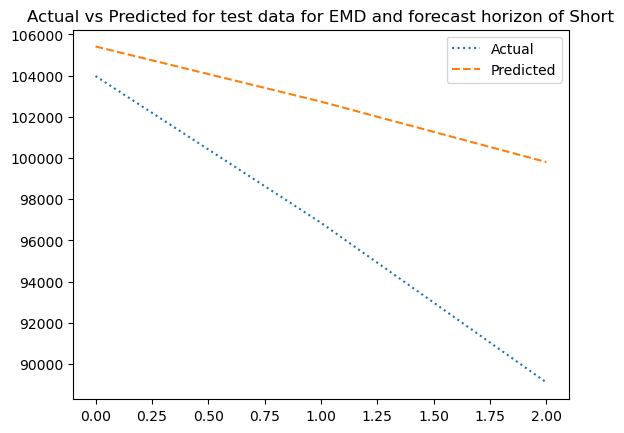

Training completed for model for time:  Medium  and model:  1
Training completed for model for time:  Medium  and model:  2
Training completed for model for time:  Medium  and model:  3
Training completed for model for time:  Medium  and model:  4
The results for time:  Medium
           RMSE          MAE      MASE      sMAPE
0  13041.521952  10341.25933  2.188163  11.699416


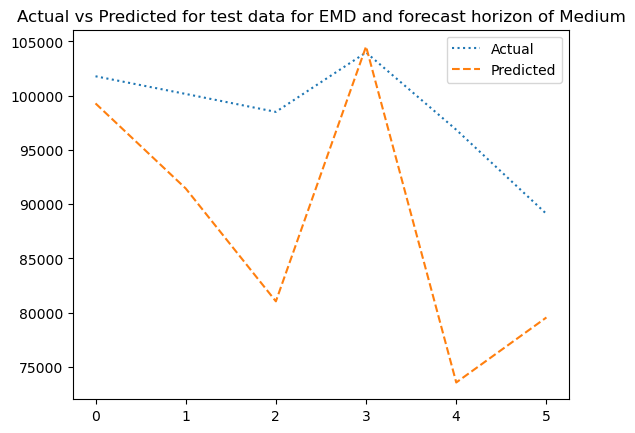

Training completed for model for time:  Long  and model:  1
Training completed for model for time:  Long  and model:  2
Training completed for model for time:  Long  and model:  3
Training completed for model for time:  Long  and model:  4
The results for time:  Long
           RMSE          MAE      MASE     sMAPE
0  10033.907396  8390.884234  1.342249  8.771945


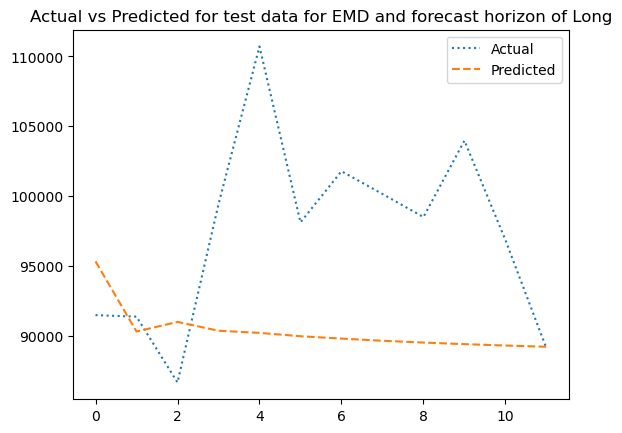

In [20]:
file_path ="Datasets/Hepatitis_dataset/China_Hepatitis_B.xlsx"
dataset = pd.read_excel(file_path)
print(dataset.head())
index_of_cases = 1
type_of_dataset = "monthly"
pred_length_weekly = {"Short": 13, "Medium": 26, "Long": 52}
pred_length_monthly = {"Short": 3, "Medium": 6, "Long": 12}


for i in range(hyperparameters.shape[0]):
    name = hyperparameters.iloc[i, 0]
    loc = name.split(" ")[0]
    dis = name.split(" ")[1]
    if loc == location and dis == disease:
        hyperparameters_index = i
        break


for time in ["Short", "Medium", "Long"]:
    p = hyperparameters[time][hyperparameters_index]
    k = (p+1)//2

    if type_of_dataset == "Weekly":
        pred_length = pred_length_weekly[time]
    else:
        pred_length = pred_length_monthly[time]

    test_size = pred_length
    valid_size = 2*pred_length
    train_size = dataset.shape[0] - test_size - valid_size-p 

    cases_time_series = dataset.iloc[:, index_of_cases].values
    cases_time_series_pruned = cases_time_series[0:train_size+valid_size+p]

    # scaling the data
    scaler = MinMaxScaler(feature_range=(-1, 1))
    cases_time_series_scaled = scaler.fit_transform(cases_time_series_pruned.reshape(-1, 1)).reshape(-1)

    emd = EMD()
    IMFs = emd(cases_time_series_scaled)
    n_imfs = IMFs.shape[0]

    X_train = []
    y_train = []
    X_valid = []
    y_valid = []

    for i in range(n_imfs):
        X, y = create_lagged_sequence(IMFs[i], p)
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        X_train.append(X[0:train_size])
        y_train.append(y[0:train_size])
        X_valid.append(X[train_size:train_size+valid_size])
        y_valid.append(y[train_size:train_size+valid_size])

    n_models = []
    for i in range(n_imfs):
        # initializing the model
        model = EWNet(p, k)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        epochs = 10000
        print_freq = 10
        epoch_freq = epochs//print_freq
        train_losses = []
        valid_losses = []

        for epoch in range(epochs):
            model.train()
            optimizer.zero_grad()
            y_train_pred = model(X_train[i])
            y_train_pred = y_train_pred.view(-1)
            loss = criterion(y_train_pred, y_train[i])
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
            with torch.no_grad():
                model.eval()
                y_valid_pred = model(X_valid[i])
                y_valid_pred = y_valid_pred.view(-1)
                valid_loss = criterion(y_valid_pred, y_valid[i])
                valid_losses.append(valid_loss.item())
        print("Training completed for model for time: ", time, " and model: ", i+1)
        n_models.append(model)
    
    y_test_pred_final = []
    for i in range(n_imfs):
        initial_input = IMFs[i][ -p:]
        y_test_pred_imfs = []
        model = n_models[i]
        model.eval()    
        with torch.no_grad():
            for j in range(test_size):
                y_pred = model(torch.tensor(initial_input[-p:], dtype=torch.float32))
                y_test_pred_imfs.append(y_pred.item())
                initial_input = np.append(initial_input, y_pred.item())
        y_test_pred_final.append(y_test_pred_imfs)
    
    y_test_pred_final = np.array(y_test_pred_final)
    y_test_pred_final = y_test_pred_final.sum(axis=0)
    y_test_pred_final = scaler.inverse_transform(y_test_pred_final.reshape(-1, 1)).reshape(-1)

    y_test_pred = np.array(y_test_pred_final)
    y_test_true = np.array(cases_time_series[-test_size:])
    rmse = np.sqrt(np.mean((y_test_pred - y_test_true)**2))
    mae = np.mean(np.abs(y_test_pred - y_test_true))
    mase = np.mean(np.abs(y_test_pred - y_test_true))/np.mean(np.abs(y_test_true[1:] - y_test_true[:-1]))
    smape = 100*np.mean(2*np.abs(y_test_pred - y_test_true)/(np.abs(y_test_pred) + np.abs(y_test_true)))
    results = pd.DataFrame({"RMSE": [rmse], "MAE": [mae], "MASE": [mase], "sMAPE": [smape]})
    print("The results for time: ", time)
    print(results)
    plt.plot(y_test_true, label="Actual", linestyle= "dotted")
    plt.plot(y_test_pred, label="Predicted", linestyle="--")
    plt.title("Actual vs Predicted for test data for EMD and forecast horizon of "+time)
    plt.legend()
    plt.show()